# Extraction d'attributs: rougeur et élongation

Dans cette feuille, vous allez implémenter l'extraction de la rougeur
et de l'élongation, les deux attributs que nous avons utilisés la
semaine dernière sur le jeu de données pommes/bananes.

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utilities import *
#import os.path
#from intro_science_donnees import data
#dataset_dir = os.path.join(data.dir, 'ApplesAndBananasSimple')
images = load_images("data/ApplesAndBananasSimple/", "*.png")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extraction du premier plan de l'image

Pour calculer les caractéristiques de nos images, nous devons d'abord
extraire le premier plan de l'image en séparant l'objet de son
arrière-plan. Pour la plupart des images de cet ensemble de données
simple, l'objet se trouve sur un fond clair. Une stratégie simple
consiste donc à choisir un seuil `theta` (*threshold* en anglais) et
décider que tout pixel dont la valeur rouge, verte ou bleue est en
dessous du seuil appartient au premier plan.

Prenons une pomme :

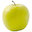

In [4]:
img = images['a10.png']
img

On calcule, pour chaque pixel, le minimum de la valeur rouge, verte et
bleue :

In [5]:
M = np.array(img)
G = np.min(M[:,:,0:3], axis=2)

Visualisons le résultat :

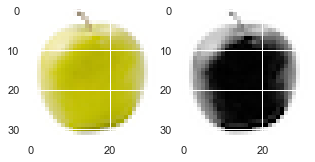

In [6]:
fig = Figure(figsize=(5,5))
ax, axr = fig.subplots(1,2)
ax.imshow(M)
axr.imshow(G, cmap='Greys_r', vmin=0, vmax=255)
fig

On choisit un seuil, ici à 150 à partir duquel on déduit un tableau
`F` de booléens où `F[i,j]` est `True` chaque fois que le pixel de
coordonnées `i`, `j` est au premier plan. Le tableau `F` peut être vu
comme une image en noir et blanc (respectivement, `False` et `True`) :

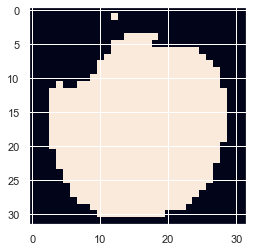

In [7]:
theta = 150
F = G < theta
plt.imshow(F);

**Exercice :** Essayez de changer la valeur de `theta`.

**Exercice :** En vous inspirant de ce qui précède, implémentez dans
<a href="utilities.py">utilities.py</a> la fonction
`foreground_filter(img, theta = 150)` qui prend comme argument un
tableau numpy `img` (c'est à dire l'image PIL) et un seuil `theta`. La
fonction renvoie une image seuillée. Vérifiez-le sur notre image:

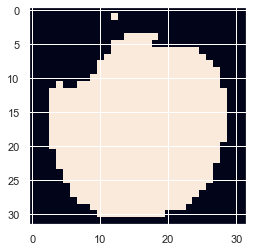

In [8]:
plt.imshow(foreground_filter(img, 150));

In [9]:
show_source(foreground_filter)

In [10]:
F = foreground_filter(img, 150)
assert isinstance(F, np.ndarray)
assert F.shape == (32, 32)
assert F.dtype == np.dtype('bool')

**Exercice :** Maintenant, appliquez le filtre avec un seuil de 200 à
toutes les images du jeu de données et affichez le résultat.

**Indications:**
- Utiliser une compréhension `[f(x) for x in ...]` pour appliquer le filtre à toutes les images.
- Utilisez `image_grid` pour afficher le résultat.

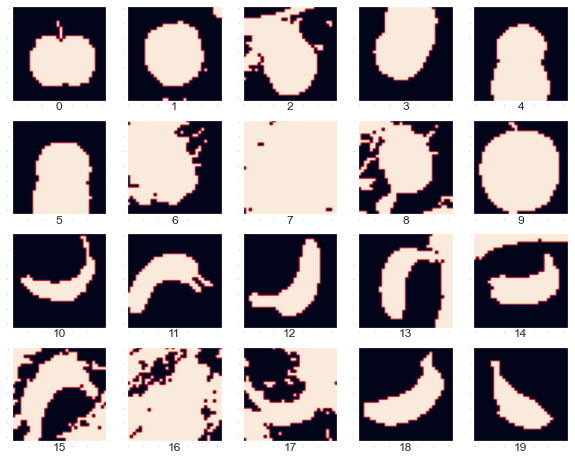

In [11]:
imgs = [foreground_filter(img,200) for img in images]
image_grid(imgs)

**Exercice :** <a href="utilities.py">utilities.py</a> fournit une fonction
`transparent_background_filter` qui appelle `foreground_filter` et
filtre tous les pixels en arrière-plan transparent. Appliquez ce
filtre à toutes les images du jeu de données et essayez différents
seuils `theta`:

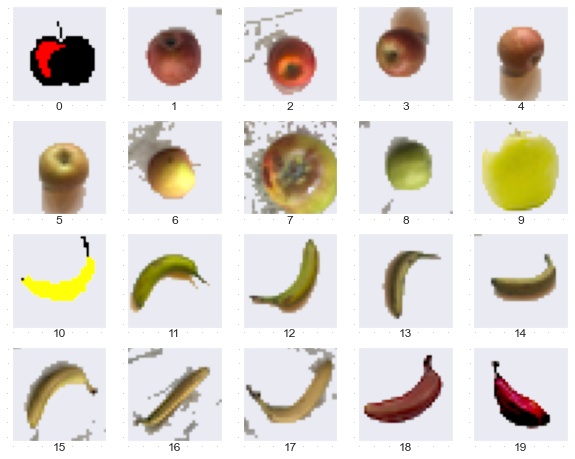

In [12]:
imgs = [transparent_background_filter(img,160) for img in images]
image_grid(imgs)

## 2. Extraction de l'attribut `rougeur` 

  
Nous voulons maintenant extraire la « rougeur » de l'image à l'aide de
la fonction `redness` d'<a href="utilities.py">utilities.py</a>. La rougeur correspond à la
moyenne (mean/average) des pixels de premier plan du canal `rouge`
(*red*) (c'est-à-dire ceux qui sont `True` in `F`) moins la moyenne
des pixels de premier plan dans le canal `vert` (*green*).

**Indications :**
- Pour calculer la moyenne, il est préférable de travailler avec des
  nombres à virgule flottante.
- Commencez par extraire, le canal vert avec `G = M[:, :, 1] *
  1.0`. Faites de meme avec le canal rouge dans un tableau `R`.
- Ensuite, sachez que si on a un tableau `R` et un tableau booléen
   (tel que `F`) de mêmes dimensions, alors `R[F]` renvoie un tableau
   avec uniquement les valeurs `R[i,j]` telles que `F[i,j]` vaut True.
- Enfin, nous rappelons que `np.mean(R)` calcule la moyenne de toutes
  les valeurs d'un tableau `R` ou `G` ;

Par exemple:

In [13]:
R = np.array([[1,2], [3,4]])
R

array([[1, 2],
       [3, 4]])

In [14]:
F = np.array([[True, False], [True, True]])
F

array([[ True, False],
       [ True,  True]])

In [15]:
R[F]

array([1, 3, 4])

**Exercice :** Implémentez la fonction `redness(img)` dans <a
href="utilities.py">utilities.py</a>.

In [16]:
show_source(redness)

Vérifiez visuellement la fonction `redness` sur les images du jeu de
données:

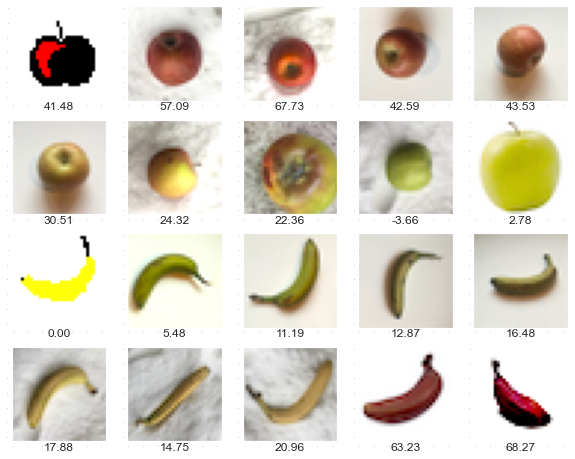

In [17]:
image_grid(images, 
           titles=["{0:.2f}".format(redness(img)) for img in images])

Vérifiez votre fonction `redness` avec les assertions suivantes:

In [18]:
assert abs(redness(images['b01.png']) -  0   ) < 0.1
assert abs(redness(images['a01.png']) - 41.48) < 0.1
assert abs(redness(images['a09.png']) - -3.66) < 0.1

## 3. Extraction de l'attribut `elongation` 

Comme second attribut pour distinguer les pommes des bananes, nous
avons extrait l'**élongation** du fruit. Cela correspond au rapport de
la longueur sur la largeur de l'objet.  Mais comment mesurer ces
caractéristiques en premier lieu, lorsque les fruits peuvent avoir
n'importe quelle orientation, et il peut y avoir du bruit dans l'image
? C'est ce que nous allons voir.

Nous profiterons de l'occasion pour montrer une astuce élégante, mise
en oeuvre dans la fonction `elongation` déjà implémentée.

**Exercice :** Afficher l'élongation de tous les fruits du jeu de
données en utilisant cette fonction `elongation` et vérifiez
visuellement que c'est plausible. Vous voudrez peut-être utiliser une
règle !

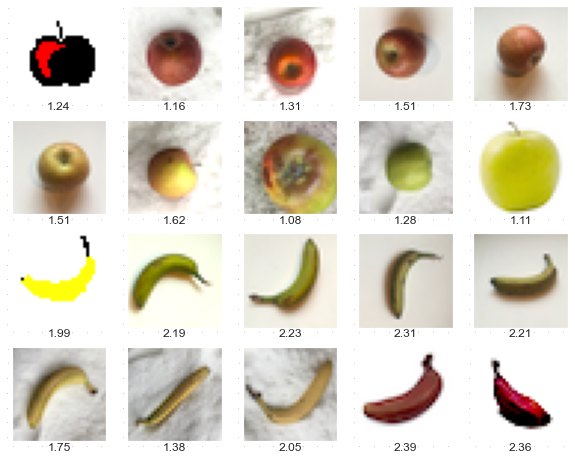

In [19]:
image_grid(images, 
           titles=["{0:.2f}".format(elongation(img)) for img in images])

Alors, comment cela marche ?

Nous convertissons l'image en noir et blanc en un nuage de points :
*Chaque point représente les coordonnées d'un des pixels de premier
plan*. Ensuite, nous identifions les **axes principaux** du nuage de
points, en utilisant un algorithme très utilisé appelé **décomposition
en valeurs singulières**. Le premier axe principal est la direction de
la **plus grande variance** du nuage de points. La seconde est la
direction orthogonale à la première.  Le rapport d'élongation sera
défini comme le rapport des écarts-types dans les deux directions
principales.

Illustrons ce principe avec une image de banane :

In [20]:
img = images['b01.png']

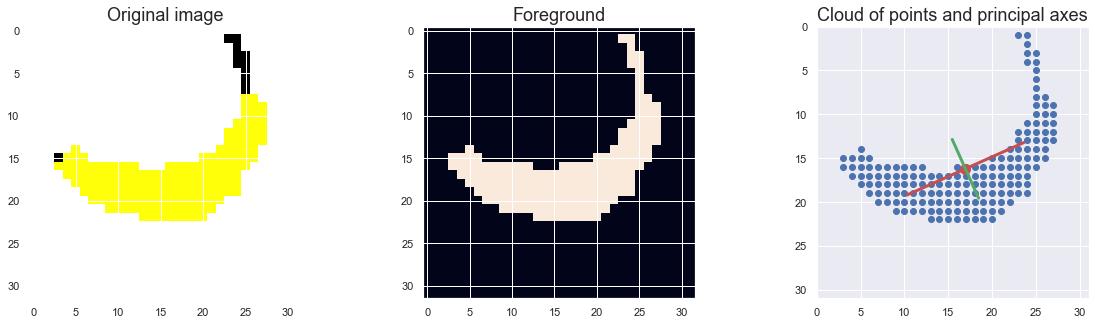

In [21]:
# Build the cloud of points defined by the foreground image pixels
F = foreground_filter(img)
xy = np.argwhere(F)
# Build the picture
fig = Figure(figsize=(20, 5))
# Original image
subplot = fig.add_subplot(1, 3, 1)
subplot.imshow(img)
subplot.set_title("Original image", fontsize=18) 
# The foreground as a black and white picture
subplot = fig.add_subplot(1, 3, 2)
subplot.imshow(foreground_filter(img))
subplot.set_title("Foreground", fontsize=18) 
# The cloud of points, as a scatter plot, together with the principal axes
subplot = fig.add_subplot(1, 3, 3)
subplot.scatter(xy[:,1], xy[:,0])
elongation_plot(img, subplot)
subplot.set_xlim(0, 31)
subplot.set_ylim(31, 0)
subplot.set_aspect('equal', adjustable='box')
subplot.set_title("Cloud of points and principal axes",  fontsize=18)
fig

**Exercice :** Essayez de nouveau avec d'autres figures

In [22]:
img = images['a02.png']

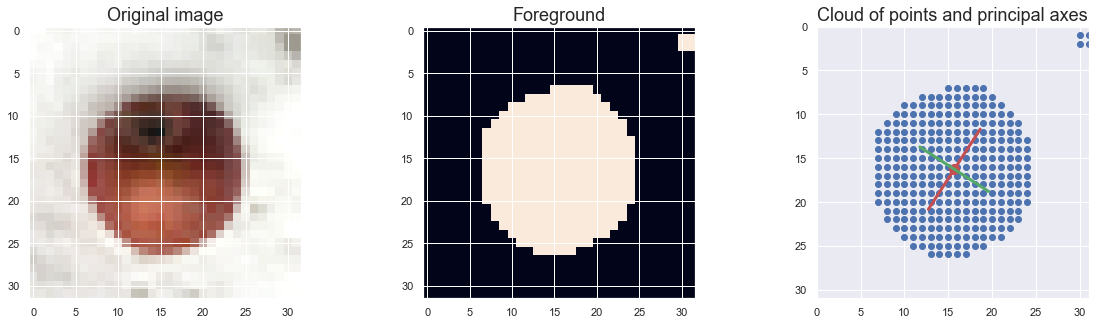

In [23]:
# Build the cloud of points defined by the foreground image pixels
F = foreground_filter(img)
xy = np.argwhere(F)
# Build the picture
fig = Figure(figsize=(20, 5))
# Original image
subplot = fig.add_subplot(1, 3, 1)
subplot.imshow(img)
subplot.set_title("Original image", fontsize=18) 
# The foreground as a black and white picture
subplot = fig.add_subplot(1, 3, 2)
subplot.imshow(foreground_filter(img))
subplot.set_title("Foreground", fontsize=18) 
# The cloud of points, as a scatter plot, together with the principal axes
subplot = fig.add_subplot(1, 3, 3)
subplot.scatter(xy[:,1], xy[:,0])
elongation_plot(img, subplot)
subplot.set_xlim(0, 31)
subplot.set_ylim(31, 0)
subplot.set_aspect('equal', adjustable='box')
subplot.set_title("Cloud of points and principal axes",  fontsize=18)
fig

<div class="alert alert-info">

L'astuce a été d'utiliser la décomposition en valeurs
singulières. Nous avons vu ce principe lors du CM4 qui parlait en
détail des ACP (Analyses en Composantes Principales, *PCA* en anglais)
sur des poissons. Vous verrez les mathématiques derrière cette méthode
dans des cours d'algèbre linéaire mais sachez que, grâce aux
bibliothèques existantes, vous pouvez déjà utiliser cette méthode en
quelques lignes !

</div>

In [24]:
show_source(elongation)

## Conclusion

<div class="alert alert-info">

**Exercice :** Ici, nous avons implémenté l'extraction de deux
attributs, suffisants pour séparer les pommes des bananes. Cherchez
quels attributs vous pourriez utiliser pour vos images et implémentez
dans <a href="utilities.py">utilities.py</a> les fonctions adéquates !
    
</div>

Mettez à jour votre rapport, puis passez à la feuille d'[analyse de
données](4_analyse_de_donnees.md).